In [2]:
%cd ..

c:\Users\Rodrigo\Documents\Projects\diffusion-planning-rl


In [9]:
%load_ext autoreload
%autoreload 2

import torch
import glob
import os
import sys
from hydra import compose, initialize
import hydra
from omegaconf import OmegaConf, SCMode

from lightning import Fabric
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


from dprl.data.utils import dotdict
from dprl.algo.seq2seq import LatentDFModel
from dprl.algo.autoencoder import CategoricalAutoEncoder
from dprl.data.datasets import LiberoDatasetAdapter
from dprl.data.utils import AtariTransform


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
try:
    initialize(version_base=None, config_path="../dprl/config")
except ValueError:
    hydra.core.global_hydra.GlobalHydra.instance().clear()
    initialize(version_base=None, config_path="../dprl/config")

cfg = compose(config_name="config", overrides=["algo=diffusion_S"])
cfg = dotdict(OmegaConf.to_container(cfg, resolve=True, structured_config_mode=SCMode.DICT_CONFIG))

In [11]:
model_path = "forced_diffusion_S"

fabric = Fabric(accelerator='gpu', precision="bf16-mixed")

def get_last_checkpoint(model_path : str):
    checkpoints = glob.glob(f"checkpoints/{model_path}/*.ckp")
    checkpoint = max(checkpoints, key=os.path.getctime)
    
    model_params = torch.load(checkpoint, weights_only=True)['model']
    
    ae : CategoricalAutoEncoder = CategoricalAutoEncoder.from_config(fabric, cfg.algo, need_optim=False)
    
    model : LatentDFModel = LatentDFModel.from_config(fabric, cfg.algo, encoder=ae.encoder, decoder=ae.decoder, action_model=ae.action_model)
    model.load_state_dict(model_params)
    
    return model
    
model = get_last_checkpoint(model_path)

Using bfloat16 Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


In [15]:
transform = AtariTransform(
        to_size=cfg.algo.encoder.in_shape[1:],
        swap_channels=True,
        num_channels=3,
        augment=False
    )

dataset = LiberoDatasetAdapter("datasets/libero_spatial",
                                slice_len=50,
                                transform=transform,
                                frameskip=1
                                )

In [16]:
def show_obs(y : torch.Tensor, frameskip : int = 10):
    if len(y.shape) == 5:
        y = y[0]
    
    y = y.cpu()
    
    trajectory_images = make_grid(y[::frameskip].flip(2), nrow=50//frameskip)
    trajectory_images = trajectory_images * 0.5 + 0.5
    
    plt.figure(figsize=(20, 2))
    plt.imshow(trajectory_images.permute(1, 2, 0))

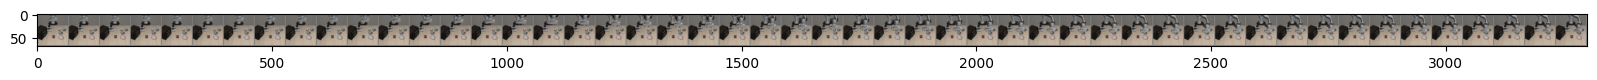

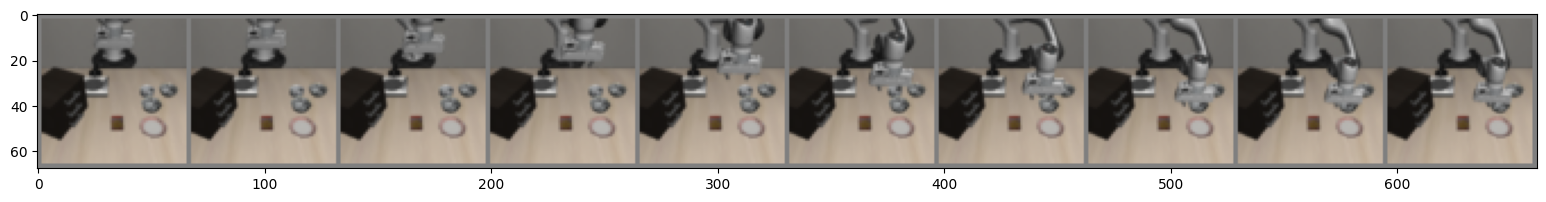

In [53]:
obs = dataset[0]['observations']
act = dataset[0]['actions'][:-1, :]

show_obs(obs, frameskip=1)
show_obs(obs, frameskip=5)

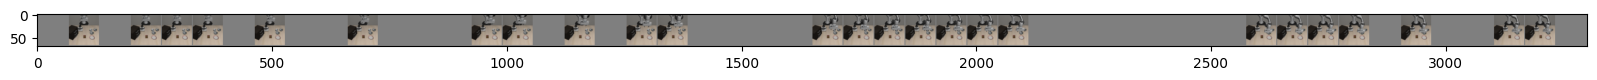

In [23]:
mask = torch.rand((obs.shape[0])) < 0.5 
show_obs(obs * mask[:, None, None, None], frameskip=1)

In [33]:
with torch.no_grad():
    	x_pred, latents = model.block_sample(dataset[0]['observations'][None, ...].to(fabric.device), need_frames=True, mask=mask, n_frames=50)
     


100%|██████████| 1000/1000 [00:07<00:00, 130.33it/s]


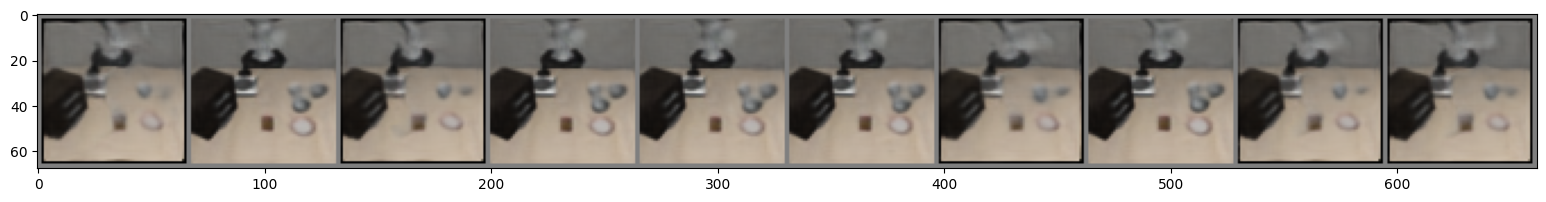

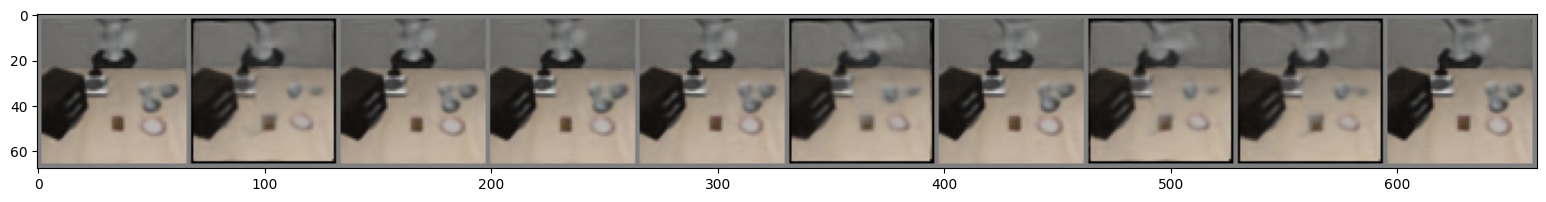

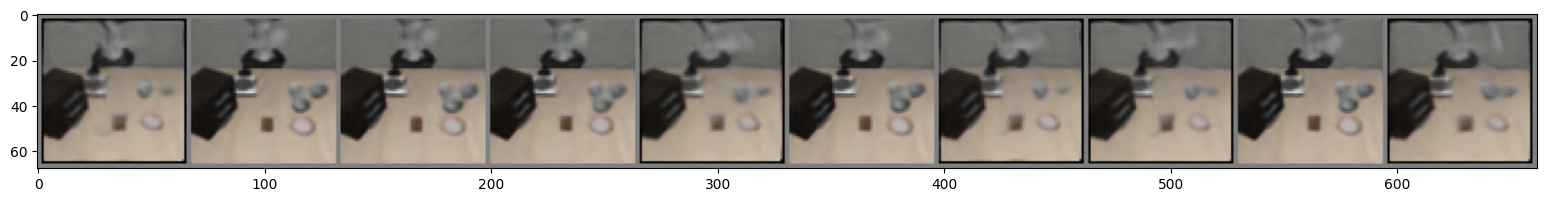

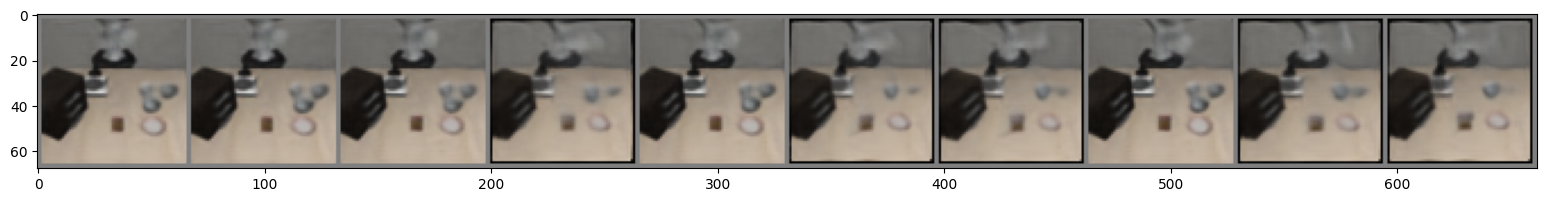

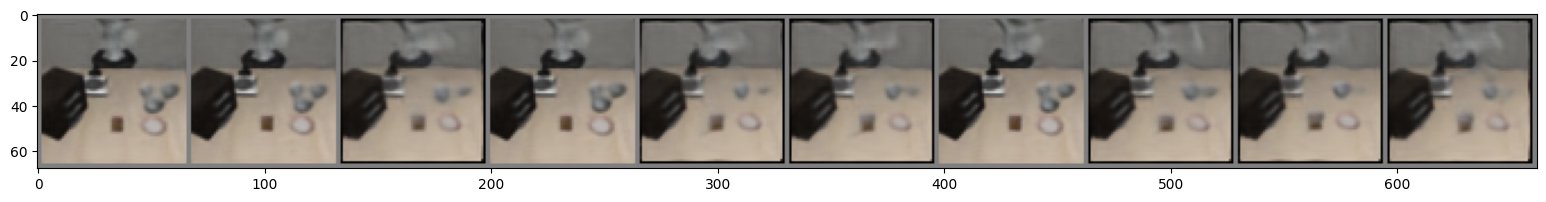

In [34]:
for i in range(5):
    show_obs(x_pred[0, i:i+10], frameskip=1)

In [44]:
z_pred = latents[-1]

In [45]:
with torch.no_grad():
    B, T, E = z_pred.shape

    z_pred = torch.as_strided(z_pred, size=(B, T - 1, E * 2), stride=(T * E, E, 1))
    action_predictions : torch.distributions.Normal = model.action_model(z_pred)


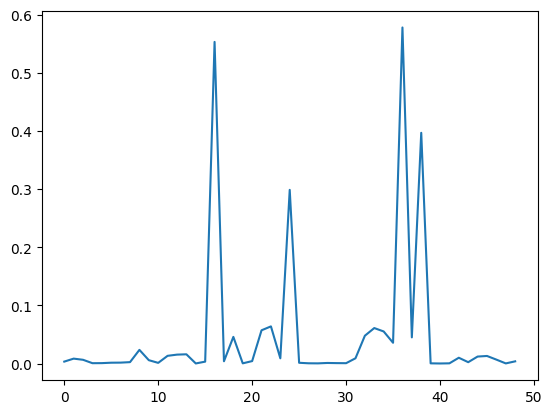

In [57]:
plt.plot(((act - action_predictions.mean[0].cpu()) ** 2).mean(-1))

Action planning kinda iffy...

In [48]:
action_predictions.mean

torch.Size([1, 49, 7])